In [1]:
import numpy
import os
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

### 1. Load Test and Train Files

In [2]:
files_train = 0
files_validation = 0

cwd = os.getcwd()
folder = 'train_data/train'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_train += len(files)


folder = 'train_data/test'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_validation += len(files)

print(files_train,files_validation)

381 164


### 2. Set key parameters

In [3]:
img_width, img_height = 48, 48
train_data_dir = "train_data/train"
validation_data_dir = "train_data/test"
nb_train_samples = files_train
nb_validation_samples = files_validation
batch_size = 32
epochs = 15
num_classes = 2

### 3. Build model on top of a trained VGG

In [4]:
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:10]:
    layer.trainable = False

In [6]:
x = model.output
x = Flatten()(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation="relu")(x)
# x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# creating the final model
model_final = Model(model.input,predictions)

# compile the model
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(learning_rate=0.0001, momentum=0.9), 
                    metrics=["accuracy"]) # See learning rate is very low

In [7]:
# Initiate the train and test generators with data Augumentation
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 381 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


In [16]:
# Save the model according to the conditions
checkpoint = ModelCheckpoint("car1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')


In [19]:
history_object = model_final.fit_generator(
train_generator,
steps_per_epoch=nb_train_samples//batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples // batch_size,
callbacks = [checkpoint, early])

C:\Users\snehal\AppData\Local\Temp\ipykernel_14916\3153849259.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_object = model_final.fit_generator(


Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9857
Epoch 1: val_accuracy improved from 0.93902 to 0.95625, saving model to car1.h5
11/11 [==============================] - 17s 2s/step - loss: 0.0483 - accuracy: 0.9857 - val_loss: 0.1360 - val_accuracy: 0.9563
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9857
Epoch 2: val_accuracy did not improve from 0.95625
11/11 [==============================] - 15s 1s/step - loss: 0.0458 - accuracy: 0.9857 - val_loss: 0.1556 - val_accuracy: 0.9500
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9885
Epoch 3: val_accuracy did not improve from 0.95625
11/11 [==============================] - 15s 1s/step - loss: 0.0371 - accuracy: 0.9885 - val_loss: 0.1836 - val_accuracy: 0.9312
Epoch 4/15
11/11 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9914
Epoch 4: val_accuracy did not improve from 0.95625
11/1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


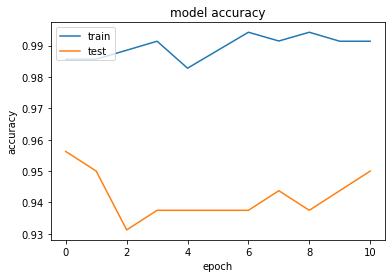

In [21]:
import matplotlib.pyplot as plt
print(history_object.history.keys())
plt.plot(history_object.history['accuracy'])
plt.plot(history_object.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

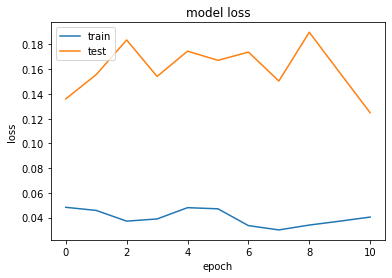

In [22]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()